In [1]:
!pip install -q yolov5 adversarial-robustness-toolbox opencv-python tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.3/953.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 593.1/593.1 kB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 102.5 MB/s et

In [2]:
import cv2
import copy
import requests
import numpy as np
from io import BytesIO
from PIL import Image
from pathlib import Path

import os
from tqdm.auto import tqdm
import shutil as sh
import random

from art.estimators.object_detection.pytorch_yolo import PyTorchYolo
from art.attacks.evasion import DPatch, RobustDPatch, HopSkipJump, DeepFool, PixelAttack

import torch
from torchvision.ops import nms

import yolov5
from yolov5.utils.loss import ComputeLoss

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# Detector Model
class Yolo(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.hyp = {
            "box": 0.05,
            "obj": 1.0,
            "cls": 0.5,
            "anchor_t": 4.0,
            "cls_pw": 1.0,
            "obj_pw": 1.0,
            "fl_gamma": 0.0,
        }
        self.compute_loss = ComputeLoss(self.model.model.model)

    def forward(self, x, targets=None):
        if self.training:
            outputs = self.model.model.model(x)
            loss, loss_items = self.compute_loss(outputs, targets)
            loss_components_dict = {"loss_total": loss}
            return loss_components_dict
        else:
            return self.model(x)


yolo = yolov5.load("yolov5l.pt")  # yolov5s.pt, yolov5l.pt, yolov5s6.pt, yolov5l6.pt

yolo_model = Yolo(yolo)
yolo_model_copied = copy.deepcopy(yolo_model)

In [4]:
# GoogleDrive Mount
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


다음 캐글 데이터를 다운 받아서 사용함 (https://www.kaggle.com/datasets/biancaferreira/african-wildlife) 

라벨 : ['buffalo', 'elephant', 'rhino', 'zebra']

우리의 목표를 코끼리를 인식하는 것으로 잡음

DeepFool attack과 HopskipJump attack은 합칠 사진도 필요하기 때문에 Zebra data도 같이 올림 (buffalo와 rhino는 없애고 zebra가 수업에서 쓰인 COCO_INSTANCE_CATEGORY_NAMES에 있어서 사용) 

--------------------------------------------------------------------------------
Downloaded and used the following Coggle data (https://www.kaggle.com/datasets/biancaferreira/african-wildlife)

Label : ['buffalo', 'elephant', 'rhino', 'zebra']

Setting our goal to recognize elephants

For DeepFool attack and HopskipJump attack, I also uploaded Zebra data because we need a picture to combine them (buffalo and rhino are deleted, zebra is used in COCO_INSTANCE_CATEGORY_NAMES used in class).

In [18]:
elephant_list = os.listdir('/content/drive/MyDrive/CPS/Data/elephant_zebra/elephant')
adversarial_list = os.listdir('/content/drive/MyDrive/CPS/Data/elephant_zebra/adversarial_elephant')
elephant_list = sorted(elephant_list)
adversarial_list = sorted(adversarial_list)
elephant_list_jpg = [img for img in adversarial_list if img.endswith(".jpg")] # Only jpg not txt
elephant_list_txt = [img for img in elephant_list if img.endswith(".txt")] # The answer of yolo
elephant_list_txt = sorted(elephant_list_txt)


zebra_list = os.listdir('/content/drive/MyDrive/CPS/Data/elephant_zebra/zebra')
zebra_list = sorted(zebra_list)
zebra_list_jpg = [img for img in zebra_list if img.endswith(".jpg")] # Only jpg not txt
zebra_list_txt = [img for img in zebra_list if img.endswith(".txt")] # The answer of yolo
zebra_list_txt = sorted(zebra_list_txt)


elephant=[]
for i in elephant_list_jpg:
  img_path = '/content/drive/MyDrive/CPS/Data/elephant_zebra/adversarial_elephant/'+i 
  img = Image.open(img_path)
  img = img.resize((640, 640)) # To unify dimension of image
  # img preprocessing
  img = np.asarray(img)  # H W C
  img_reshape = img.transpose((2, 0, 1))  # C H W
  # [C, H, W] to [N, C, H, W]
  elephant.append(img_reshape)
elephant = np.asarray(elephant).astype(np.float32)

In [19]:
print(len(elephant_list_jpg))
print(len(elephant_list_txt))

376
376


In [ ]:
zebra = []
for i in zebra_list_jpg:
  img_path = '/content/drive/MyDrive/CPS/Data/elephant_zebra/zebra/'+i 
  img = Image.open(img_path)
  img = img.resize((640, 640)) # To unify dimension of image
  # img preprocessing
  img = np.asarray(img)  # H W C
  img_reshape = img.transpose((2, 0, 1))  # C H W
  # [C, H, W] to [N, C, H, W]
  zebra.append(img_reshape)
zebra = np.asarray(zebra).astype(np.float32)

image 1/1: 640x640 2 elephants
Speed: 23.9ms pre-process, 2618.3ms inference, 3.3ms NMS per image at shape (1, 3, 640, 640)


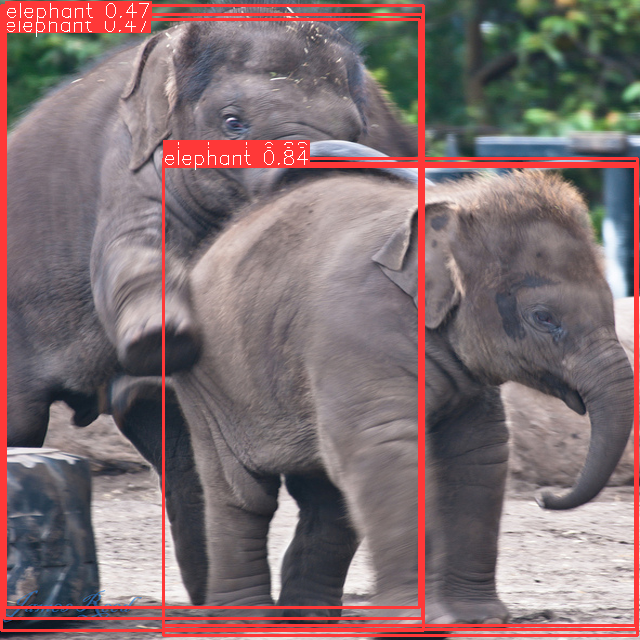

In [ ]:
#test_pred_elephant = yolo_model.model(elephant[0][0])  # yolo_model_copied
#test_pred_elephant.print()
#test_pred_elephant.show()

image 1/1: 640x640 1 zebra
Speed: 4.2ms pre-process, 2797.0ms inference, 1.8ms NMS per image at shape (1, 3, 640, 640)


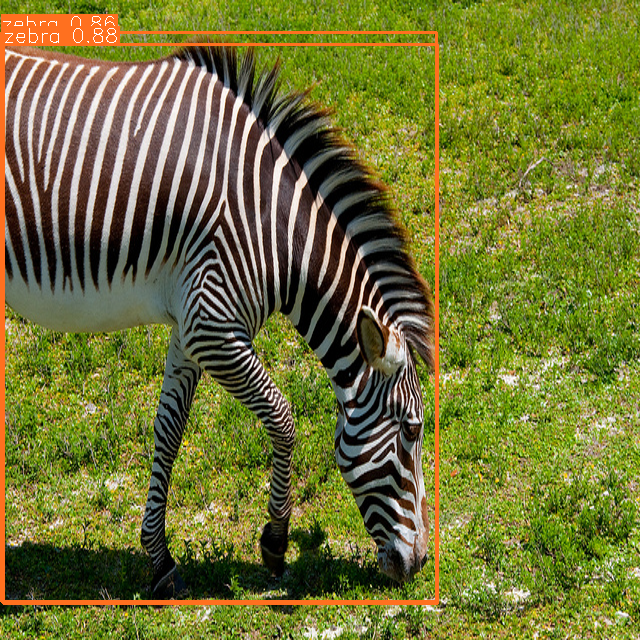

In [ ]:
#test_pred_zebra = yolo_model.model(zebra[0][0])  # yolo_model_copied
#test_pred_zebra.print()
#test_pred_zebra.show()

In [20]:
target_lable = ['elephant', 'zebra'] # label [1,3]

# Purpose is selecting boxes elephant exists. 

"""
#################        COCO LABELS          #################
"""

COCO_INSTANCE_CATEGORY_NAMES = [
    "person", "bicycle", "car", "motorcycle", "airplane",
    "bus", "train", "truck", "boat", "traffic light",
    "fire hydrant", "stop sign", "parking meter", "bench", "bird",
    "cat", "dog", "horse", "sheep", "cow",
    "elephant", "bear", "zebra", "giraffe", "backpack",
    "umbrella", "handbag", "tie", "suitcase", "frisbee",
    "skis", "snowboard", "sports ball", "kite", "baseball bat",
    "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle",
    "wine glass", "cup", "fork", "knife", "spoon",
    "bowl", "banana", "apple", "sandwich", "orange",
    "broccoli", "carrot", "hot dog", "pizza", "donut",
    "cake", "chair", "couch", "potted plant", "bed",
    "dining table", "toilet", "tv", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven",
    "toaster", "sink", "refrigerator", "book", "clock",
    "vase", "scissors", "teddy bear", "hair drier", "toothbrush",
]

In [21]:
"""
#################        EXPERIMENTS UTILS        #################
"""
def extract_predictions(predictions_, conf_thres, iou_thres):
    # Get the predicted class
    predictions_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(predictions_["labels"])]
    
    if len(predictions_class) < 1:
        return [], [], []

    # Get the predicted bounding boxes
    predictions_box = [i[:4] for i in list(predictions_["boxes"])]

    # Get the predicted prediction score
    predictions_score = list(predictions_["scores"])

    # Get a list of index with score greater than threshold
    threshold = conf_thres
    predictions_t = [predictions_score.index(x) for x in predictions_score if x > threshold]
    if len(predictions_t) == 0:
        return [], [], []

    # predictions in score order
    predictions_boxes = [predictions_box[i] for i in predictions_t]
    predictions_classes = [predictions_class[i] for i in predictions_t]
    predictions_scores = [predictions_score[i] for i in predictions_t]

    nms_result = nms(boxes=torch.tensor(predictions_boxes), 
                     scores=torch.tensor(predictions_scores), 
                     iou_threshold=iou_thres,
                     )
    
    nms_classes = [predictions_classes[i] for i in nms_result]
    nms_boxes = [predictions_boxes[i] for i in nms_result]
    nms_scores = [predictions_scores[i] for i in nms_result]

    # print(nms_classes, nms_boxes, nms_scores)

    return nms_classes, nms_boxes, nms_scores


def plot_image_with_boxes(img, boxes, pred_cls, pred_score, title):
    # plt.style.use("ggplot")
    text_size = 1
    text_th = 3
    rect_th = 3

    for i in range(len(boxes)):
        cv2.rectangle(
            img,
            (int(boxes[i][0]), int(boxes[i][1])),
            (int(boxes[i][2]), int(boxes[i][3])),
            color=(204, 237, 0),
            thickness=rect_th,
        )
        # Write the prediction class
        cv2.putText(
            img,
            f"{pred_cls[i]}: {pred_score[i]*100:.1f}",
            (int(boxes[i][0]), int(boxes[i][1])+30),
            cv2.FONT_HERSHEY_SIMPLEX,
            text_size,
            color=(204, 237, 0),
            thickness=text_th,
        )

    plt.figure()
    plt.axis("off")
    plt.title(title)
    plt.imshow(img.astype(np.uint8), interpolation="nearest")
    plt.show()

In [22]:
"""
#################        CONSTANT CONFIGURATION          #################
"""

patch_shape = (3, 120, 120)  # C H W
max_iter = 100
batch_size = 16
lr=5.0
conf_thres = 0.25
iou_thres = 0.45
is_targeted = False
"""
#####################  MAKE A DETECTOR For Adversarial Data ########################3
"""
detector = PyTorchYolo(model=yolo_model,
                       device_type="gpu",
                       input_shape=(3, 640, 640),
                       clip_values=(0, 255),
                       attack_losses=("loss_total",)
                      )

"""
#####################  MAKE A COPIED DETECTOR  FOR Origin Data ########################3
"""
detector_copied = PyTorchYolo(model=yolo_model_copied,
                              device_type="gpu",
                              input_shape=(3, 640, 640),
                              clip_values=(0, 255),
                              attack_losses=("loss_total", )
)

In [23]:
pred_clean = detector_copied.predict(x=elephant)


Predictions image 275:


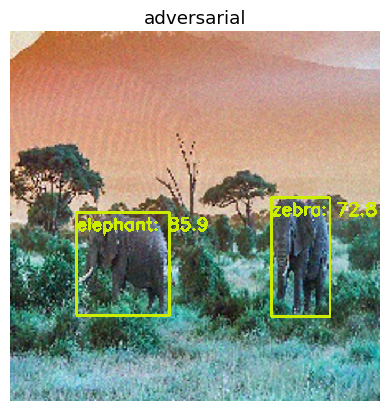


Predictions image 289:


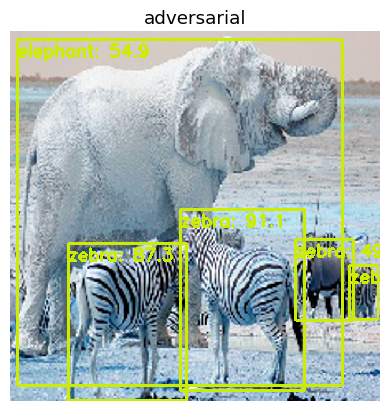


Predictions image 289:


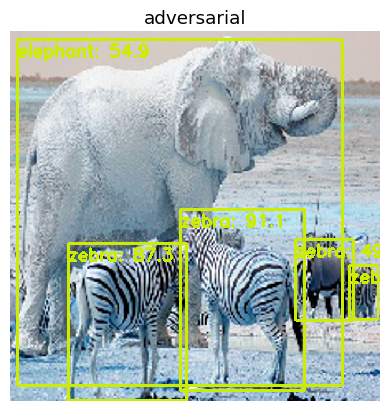

In [25]:
def find_indices(lst, value):
    return [i for i, x in enumerate(lst) if x == value]

threshold = 0.5
pred_coordinate = []

for i in range(elephant.shape[0]):
    # Process predictions
    pred_classes, pred_boxes, pred_scores = extract_predictions(pred_clean[i], conf_thres=conf_thres, iou_thres=iou_thres)
    idx_all = find_indices(pred_classes, 'zebra')
    idx = []
    one_img_coor=[]
    for img in idx_all:
      if pred_scores[img] >= threshold:
        idx.append(img)
        one_img_coor.append(list(pred_boxes[img]))
        print(f"\nPredictions image {i}:")
        plot_image_with_boxes(img=elephant[i].transpose(1, 2, 0).copy(),
                          boxes=pred_boxes,
                          pred_cls=pred_classes,
                          pred_score=pred_scores,
                          title='adversarial')
    pred_coordinate.append(one_img_coor)
    # Plot predictions
    if i > 20:
        continue


In [33]:
def find_indices(lst, value):
    return [i for i, x in enumerate(lst) if x == value]

threshold = 0.5
pred_coordinate = []

for i in range(elephant.shape[0]):
    # Process predictions
    pred_classes, pred_boxes, pred_scores = extract_predictions(pred_clean[i], conf_thres=conf_thres, iou_thres=iou_thres)
    idx_all = find_indices(pred_classes, 'elephant')
    idx = []
    one_img_coor=[]
    for img in idx_all:
      if pred_scores[img] >= threshold:
        idx.append(img)
        one_img_coor.append(list(pred_boxes[img]))
    pred_coordinate.append(one_img_coor)
    # Plot predictions
    print(f"\nPredictions image {i}:")
    plot_image_with_boxes(img=elephant[i].transpose(1, 2, 0).copy(),
                          boxes=pred_boxes,
                          pred_cls=pred_classes,
                          pred_score=pred_scores,
                          title='adversarial')

Output hidden; open in https://colab.research.google.com to view.

In [27]:
# elephant_list_txt, zebra_list_txt
# Label_ID_1 X_CENTER_NORM Y_CENTER_NORM WIDTH_NORM HEIGHT_NORM
# convert the norm to the coordinates

def convert_norm_to_coordinates(x_center_norm, y_center_norm, width_norm, height_norm, image_width=640, image_height=640):
    x_center = x_center_norm * image_width
    y_center = y_center_norm * image_height
    width = width_norm * image_width
    height = height_norm * image_height

    x_min = x_center - (width / 2)
    y_min = y_center - (height / 2)
    x_max = x_center + (width / 2)
    y_max = y_center + (height / 2)

    return [x_min, y_min, x_max, y_max]

In [28]:
answer_coordinates = []

for i in elephant_list_txt:
  txt_path = '/content/drive/MyDrive/CPS/Data/elephant_zebra/elephant/'+i 
  with open(txt_path, 'r', encoding='utf-8') as file:
      content = file.read()
      elephants = content.split('\n')
      elephants = list(filter(None, elephants))
      one_img = []
      for an_elephaant in elephants:
        normlist = an_elephaant.split(' ')[1:]
        coor = convert_norm_to_coordinates(float(normlist[0]),float(normlist[1]),float(normlist[2]),float(normlist[3]))
        one_img.append(coor)
      answer_coordinates.append(one_img)

In [ ]:
# precision = TP / TP+FP  : True라고 한것중 True의 비중
# recall = TP / TP+FN : 실제 True 중에 맞춘 True의 비중

In [29]:
def draw_bboxes(bboxes):
    if not bboxes:
        return None

    # 일단 검정 이미지 생성
    img = np.zeros((640, 640, 3), dtype=np.uint8)
    # 사각형들의 영역을 이미지에 그리기
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        x_min = round(x_min)
        y_min = round(y_min)
        x_max = round(x_max)
        y_max = round(y_max)
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 255, 255), thickness=-1)
    return img

#a= draw_bboxes([(142.0, 29.976320000000044, 586.99968, 638.5011200000001), (451.0, 2.997759999999971, 637.0, 640.0)])
#img_2 = Image.fromarray(a) # NumPy array to PIL image
#img_2.show()

compare answer_coordinates and pred_coordinate

precision = union / pred

recall = union / answer

1. make union area in each coordinate
2. make union area by using answer and prediction
3. Use 1,2 to calculate precision and recall

In [30]:
pred_elephant_img = []
for coor in pred_coordinate:
  pred_elephant_img.append(draw_bboxes(coor))

answer_elephant_img = []
for coor in answer_coordinates:
  answer_elephant_img.append(draw_bboxes(coor))
  

In [31]:
def calculate_brightness_area(img_array, brightness=(255, 255, 255)):
    # 이미지 크기 확인
    height = 640
    width = 640
    # 밝기가 일치하는 픽셀 개수 초기화
    matching_pixels = 0
    # 이미지의 모든 픽셀 비교
    for y in range(height):
        for x in range(width):
            if np.all(img_array[y, x] == brightness):
                matching_pixels += 1
    # 픽셀 단위의 넓이 계산
    brightness_area = matching_pixels / (height * width)
    print(f'bright_area : {matching_pixels}')
    return brightness_area

def performance_evaluation(img1_array, img2_array):
    if img1_array is None or img2_array is None:
      return [0,0]
    # 이미지 크기 확인
    height = 640
    width = 640
    # 같은 색상을 가진 픽셀 개수 초기화
    matching_pixels = 0
    # 두 이미지의 픽셀 비교
    for y in range(height):
        for x in range(width):
            if np.all((img1_array[y, x] == (255, 255, 255)) & (img2_array[y, x]==(255, 255, 255))):
                matching_pixels += 1
    # 픽셀 단위의 넓이 계산
    matching_area = matching_pixels / (height * width)
    print(f'matching_Area : {matching_pixels}')
    answer_area = calculate_brightness_area(img1_array)
    pred_area = calculate_brightness_area(img2_array)

    precision = matching_area/pred_area
    recall = matching_area/answer_area
    return [precision, recall]


In [32]:
precision = 0
recall = 0
for idx in tqdm(range(376)): # len(answer_elephant_img):
  precision_recall = performance_evaluation(answer_elephant_img[idx], pred_elephant_img[idx])
  precision += precision_recall[0]
  recall += precision_recall[1]
  print(f'{idx}번째 이미지 precision : {precision_recall[0]}')
  print(f'{idx}번째 이미지 recall : {precision_recall[1]}')

precision = precision/376 * 100
recall = recall/376 * 100

print(f"adversarial Image Precision : {precision}%")
print(f"adversarial Image recall : {recall}%")

  0%|          | 0/376 [00:00<?, ?it/s]

0번째 이미지 precision : 0
0번째 이미지 recall : 0
matching_Area : 71780
bright_area : 307609
bright_area : 98940
1번째 이미지 precision : 0.7254901960784313
1번째 이미지 recall : 0.2333481790194695
2번째 이미지 precision : 0
2번째 이미지 recall : 0
3번째 이미지 precision : 0
3번째 이미지 recall : 0
4번째 이미지 precision : 0
4번째 이미지 recall : 0
matching_Area : 233871
bright_area : 237872
bright_area : 270702
5번째 이미지 precision : 0.8639426380300109
5번째 이미지 recall : 0.9831800295957491
matching_Area : 318573
bright_area : 326858
bright_area : 318573
6번째 이미지 precision : 1.0
6번째 이미지 recall : 0.9746526014354858
matching_Area : 169420
bright_area : 183168
bright_area : 170208
7번째 이미지 precision : 0.9953703703703705
7번째 이미지 recall : 0.9249432215234102
8번째 이미지 precision : 0
8번째 이미지 recall : 0
9번째 이미지 precision : 0
9번째 이미지 recall : 0
10번째 이미지 precision : 0
10번째 이미지 recall : 0
matching_Area : 215790
bright_area : 220710
bright_area : 274800
11번째 이미지 precision : 0.7852620087336245
11번째 이미지 recall : 0.9777083050156314
matching_Area : 210608
bri